--------------------------
# [**HW 3**](https://github.com/lucamaiano/ADM/tree/master/2022/Homework_3) - Places of the World
------------------------------------

In [1]:
import time
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate

### Data collection:
**Collectings URLs** of the places listed in **the first 400 pages** of [**Atlas Obscura**](https://www.atlasobscura.com/)

In [2]:
import requests
from bs4 import BeautifulSoup as bs

In [3]:
tot_pages = 400     # number of pages requested
page = 1            # set counter
urls = []           # empty list to store URLs

with tqdm( total = tot_pages, position=0, leave=True) as pbar:
    
    while page < (tot_pages + 1):
        
        url = f"https://www.atlasobscura.com/places?page={page}&sort=likes_count"
        
        # make a request to web page and retrive HTML code
        
        result = requests.get(url, headers = {'User-agent': 'your bot 1.1'}) 
        soup = bs(result.text, 'html.parser')        # parsing HTML with BeautifulSoup
        
        if result.status_code == requests.codes.ok:  # check the response status code
        
            for a in soup.find_all('a',{"class":"content-card content-card-place"}, href=True):
            
                urls.append(a['href'])    # store URLs in list
                
            pbar.update()
            page = page+1
                       
print(" URLs found : {}\t unique URLs : {}".format(len(urls),len(set(urls))))

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [06:40<00:00,  1.00s/it]

 URLs found : 7200	 unique URLs : 7200


Parsing html code of each place's page (7200) to retrieve:

1. Place Name (to save as `placeName`): string.
2. place Location (to save as `placeLocation`): string
3. Short Description (to save as `placeShortDesc`): string.
4. Number of people who have been there (to save as `numPeopleVisited`): integer.
5. Nuber of people who want to visit the place (to save as `numPeopleWant`): integer.
6. Description (to save as `placeDesc`): string.
7. Address (to save as `placeAddress`): string.
8. Latitud and Longitude of the place's location (to save as `placeAlt` and `placeLong`): floats.
9. Post publishing date (to save as `placePubDate`): datetime.
10. The names of the related places (to save as `placeRelatedPlaces`): list of strings.
11. The names of the nearby places (to save as `placeNearby`): list of strings.
12. Place Tags (to save as `placeTags`): list of strings.
13. The username of the post editors (to save as `placeEditors`): list of strings.
14. The URL of the page of the place (to save as `placeURL`): string


In [4]:
def extract_single_place(zuppa : bs):
    
    placeName = zuppa.find_all("h1", {"class": "DDPage__header-title"})[0].contents[0].text
    placeLocation = zuppa.find_all("div", {"class": "DDPage__header-place-location"})[0].text
    placeShortDesc = zuppa.find_all("h3", {"class": "DDPage__header-dek"})[0].contents[0].text
    numPeopleVisited = int(zuppa.find_all("div", {"class": "title-md item-action-count"})[0].contents[0].text)                  
    numPeopleWant = int(zuppa.find_all("div", {"class": "title-md item-action-count"})[1].contents[0].text)
    placeDesc = zuppa.find_all("div", {"id": "place-body"})[0].text.replace("\n",'')
    placeAddress = str(zuppa.find_all("aside", {"class": "DDPageSiderail__details"})[0].contents[1].text).replace("\n","")
    placeAlt_placeLong = str(zuppa.find_all("aside", {"class": "DDPageSiderail__details"})[0].contents[3].text).replace("\n","").split(",")
        
    try:
        placePubDate = zuppa.find_all("div", {"class": "DDPContributor__name"})[0].text
        placePubDate = None if len(placePubDate) == 0 else placePubDate
    except IndexError: placePubDate = None
            
    try:
        my_div = zuppa.find_all("div", {"class": "card-grid CardRecircSection__card-grid js-inject-gtm-data-in-child-links"})[1]           
        placeRelatedPlaces = [i.contents[1].text for i in my_div.find_all("h3", {"class":"Card__heading --content-card-v2-title js-title-content"})]
        placeRelatedPlaces = None if len(placeRelatedPlaces) == 0 else placeRelatedPlaces
    except IndexError: placeRelatedPlaces = None
            
    try:
        my_div0 = zuppa.find_all("div", {"class": "card-grid CardRecircSection__card-grid js-inject-gtm-data-in-child-links"})[0]
        placeNearby = [i.contents[1].text for i in my_div0.find_all("h3", {"class":"Card__heading --content-card-v2-title js-title-content"})]
        placeNearby = None if len(placeNearby) == 0 else placeNearby
    except IndexError: placeNearby = None
            
    try:
        tag = soup.find_all("div", {"class": "item-tags col-xs-12"})[0]
        place_tag = [i.contents[0].text.replace("\n","") for i in tag.find_all("a")]
        place_tag = None if len(place_tag) == 0 else place_tag
    except IndexError: place_tag = None
        
    try:
        placeEditors = soup.find_all("a", {"class": "DDPContributorsList__contributor"}, href=True)                                        #11
        placeEditors = [x.text.replace("\n","") for x in placeEditors]
        placeEditors = None if len(placeEditors) == 0 else placeEditors
    except IndexError: placeEditors = None
            
            
    data = {"placeName" : placeName, "placeLocation" : placeLocation, "numPeopleVisited" : numPeopleVisited,
            "numPeopleWant" : numPeopleWant, "placeDesc" : placeDesc, "placeShortDesc" : placeShortDesc, 
            "placeAddress" : placeAddress, "placeAlt" : placeAlt_placeLong[0], "placeLong" :placeAlt_placeLong[1],
            "placePubDate" :placePubDate,  "placeTags" : place_tag, 
            "placeNearby" : placeNearby, "placeRelatedPlaces": placeRelatedPlaces, "placeEditors" : placeEditors}
        
    return data


Build the DataFrame :

In [ ]:
data = pd.DataFrame()

for i in tqdm(range(len(urls))):
    
    u = 'https://www.atlasobscura.com' + urls[i]
    result = requests.get( url = u, headers = {'User-agent': 'your bot 1.1'})
    
    if result.status_code == requests.codes.ok:
        
        soup = bs(result.text, 'html.parser')
        d = extract_single_place(soup)
        d["placeUrl"] = u
        data = data.append(d, ignore_index=True)
        
    else:
        time.sleep(160)
        i = i-1
        
# if not all places are collected, do the request again for those URLs that are not in data['placeUrl'] column

In [7]:
print("data.shape :", data.shape)
print("\nMissing values in DataFrame :\n", data.isna().sum().sort_values(ascending = True), sep="\n")

data.shape : (7200, 15)

Missing values in DataFrame :

placeName              0
numPeopleVisited       0
numPeopleWant          0
placeDesc              0
placeShortDesc         0
placeAddress           0
placeAlt               0
placeLong              0
placeUrl               0
placeLocation          1
placePubDate           1
placeNearby            1
placeEditors           6
placeRelatedPlaces    29
placeTags             34
dtype: int64


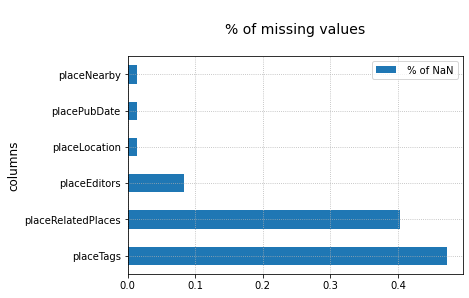

In [80]:
na_df = (data.isnull().sum() / len(data)) * 100
na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending = False)
na_df = pd.DataFrame({' % of NaN' : na_df})
ax = na_df.plot(kind = "barh")
ax.grid(linestyle = ':')
ax.set_title("\n% of missing values\n", fontsize=14)
ax.set_ylabel("columns", fontsize=12);

In [9]:
data.to_csv("data_data.csv", sep= '\t', encoding = 'utf-8')

-----------------------------------------------------------------------------------

## Search Engines :

<br>

In [3]:
from engine import module

In [4]:
data = pd.read_csv('data_data.csv', sep = "\t", index_col = 0)

N = data.shape[0]  ## 𝑁 = 7200 (total number of documents in the Corpus)

print("\n data.shape :", data.shape)


 data.shape : (7200, 15)


In [5]:
display(data.head(3))
tqdm.pandas()

,placeName,placeLocation,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeAddress,placeAlt,placeLong,placePubDate,placeTags,placeNearby,placeRelatedPlaces,placeEditors,placeUrl
0,City Hall Station,"Manhattan, New York",1885.0,8992.0,The first New York City subway was built and o...,A beautiful and abandoned New York subway stat...,"31 Centre StNew York, New York, 10007United St...",40.7134,-74.0046,"May 8, 2010","['subways', 'subterranean', 'infrastructure', ...","['African Burial Ground National Monument', 'T...","['Crystal Palace Subway', 'Moscow Metro Statio...","['Rebekah Otto', 'wythe', 'Allan', 'jrc2692', ...",https://www.atlasobscura.com/places/city-hall-...
1,Highgate Cemetery,"London, England",2761.0,8529.0,"Opened in 1839, Highgate is one of London’s mo...",London's creepiest cemetery was once the site ...,"Swain's Lane, HighgateLondon, England, N6Unite...",51.5675,-0.1483,"August 9, 2014","['rivals week', 'vampires', 'hoaxes', 'occult'...","[""World's Largest Potted Plant"", 'Dick Whittin...","['Jewett City Vampires', 'Tomb of the Mather F...","['Rob', 'SEANETTA', 'TeaAndCoffeeLover', 'Gavi...",https://www.atlasobscura.com/places/highgate-c...
2,Leadenhall Market,"London, England",3314.0,8063.0,The ornate 19th-century painted roof and cobbl...,This ornate Victorian marketplace was the sett...,"London, England, EC3VUnited Kingdom",51.5126,-0.0834,"August 1, 2016","['markets', 'film locations', 'film']","['The Cornhill Devils ', ""London's Original an...","['Site of Charlie Chaplin Studios', 'Rivendell...","['Meg', 'lili', 'Julius Spada', 'Martin', 'jul...",https://www.atlasobscura.com/places/leadenhall...


--------------------------------------

Standard **text pre-processing** procedures performed via the `preprosessing` function imported from `main.py`

This function takes long a string as input and returns preprocessed token list. Pre-processing consists of the following operations:

- Removing non-alphanumeric characters using `regular expressions`:\
    The `re.sub` function is used to replace characters that are not letters or numbers with a blank space.


- Removing **punctuation** using the `translate()` method and the `str.maketrans()` function


- **Tokenization**: the preprocessed string is split into a list of words using a blank space as a delimiter.\
    Converting tokens to lowercase: Each word in the list is converted to lowercase using the `lower()` method.


- Removing **StopWords** using the **NLTK library**:\
    The list of tokens is compared to a set of common English words (stopwords) and the matching words are removed from the     list.
    

- **Stemming** with **NLTK library**:\
   Remaining words in list are reduced to their stem using the Porter stemming algorithm implemented with `PorterStemmer()`
 
 
- Non-alphabetic word removal: word list is filtered to remove any numbers or symbols.

Finally, the function returns the preprocessed word list as output.

In [6]:
st = time.time()
data['list_words'] = data["placeDesc"].progress_apply(lambda desc: module.preprocess(desc))
et = time.time()

print('Execution time:', str(datetime.timedelta(seconds = et - st))[:10] , 'seconds')

100%|█████████████████████████████████████████████████████████████████████████████| 7200/7200 [00:28<00:00, 254.54it/s]


Execution time: 0:00:28.29 seconds


The `apply()` method is used to apply a lambda function to each row of the `placeDesc` column.\
The **lambda** function calls a `preprocess()` function from a module, passing in the value of `placeDesc`.\
The result of the function is assigned to the new `list_words` column.


In [7]:
print(" data.shape :", data.shape, '\n')

print("Document 4472:\n")
print(" - placeName : ", data['placeName'][4472])
print(' - placeDesc :', '"'+data['placeDesc'][4472][:87]+'..."')
print(' - listWords :', str(data['list_words'][4472][:8]).split("]")[0]+", ... ]")

 data.shape : (7200, 16) 

Document 4472:

 - placeName :  Vienna Grand Ferris Wheel
 - placeDesc : "Vienna’s grand ferris wheel, the Wiener Riesenrad, was, until 1985, the largest in the ..."
 - listWords : ['vienna', 'grand', 'ferri', 'wheel', 'wiener', 'riesenrad', 'largest', 'world', ... ]


-------------------------------------------

Build a dictionary named **Vocabulary**. It is  a `Counter` object that maps each word to its frequency in the **Corpus of documents**\
Vocabulary: `keys` are unique tokenized words in corpus of documents, `values` their count in Courpus

The `reduce()` function is used in combination with a `lambda` function to concatenate all the words in the `list_words` column into a single string.\
The resulting string is then passed to the `Counter()` constructor, which creates the mapping of word counts.

In [8]:
from collections import Counter 
from functools import reduce

In [10]:
st = time.time()
vocabulary = Counter(reduce(lambda x, y: x + y, data.list_words))
et = time.time()

n_tokens = len(vocabulary.keys())  # = 63641

print('Execution time:', str(datetime.timedelta(seconds = et - st))[:10], 'minutes')

Execution time: 0:01:35.97 minutes


Create a dictionary `word_dict` that maps unique words in the corpus to an **integer ID**, starting from 1:

In [11]:
word_dict = {}      # initialize empty dictionary
item_id = 1         # set term_id counter

for word in vocabulary.keys():  # iterating over unique words in corpus of documents
    word_dict[word] = item_id   # assign an integer = term_id to each word 
    item_id += 1

In [12]:
es = ['london', 'park', 'museum', 'food', 'vienna']

table = zip([word_dict[x] for x in es], ["'"+ x +"'" for x in es], [vocabulary[x] for x in es])

print("\n", tabulate(list(table), headers=["id :", "words :", "occurrence :"], 
                                 numalign='center', stralign="center"))

print("\n   'Vocabulary' :  {}   lenght = {} ".format(type(vocabulary), len(vocabulary.keys())),'\n')


  id :    words :    occurrence :
------  ---------  --------------
 130    'london'        564
 136     'park'         3118
 119    'museum'        3882
 5823    'food'         500
10833   'vienna'         77

   'Vocabulary' :  <class 'collections.Counter'>   lenght = 63641  



In [13]:
c, ind_dic = 1, {}              ## N.B.
for key in word_dict.keys():   ## we will need 'ind_dic' in order to retrieve words form their IDs
    ind_dic[c] = key           
    c+=1                      

-----------------------------------------
Create an **Inverted Index** dictionary called `inverted_idx` from the words in `word_dict`.

For each `(word, item_id)` pair in `word_dict`, add an entry to `inverted_idx` where:
- the **key** is the `item_id` 
- the **value** is a list of indexes where the corresponding `word` appears in the `list_words` column of the DataFrame.

The `apply` method is used to apply the lambda function to each row in the `list_words` column of the DataFrame.\
The **lambda** function checks whether `word` is in the row, and the resulting Boolean values are used to filter the rows.


In [14]:
import pickle

In [15]:
with open('II_v1.pkl', 'rb') as f:
    inverted_idx = pickle.load(f)

In [17]:
inverted_idx = {}   

for (word, item_id) in tqdm(word_dict.items()):
    
    inverted_idx[item_id] = list( data [ data.list_words.apply(lambda row: word in row) ].index)

100%|████████████████████████████████████████████████████████████████████████████| 63641/63641 [38:19<00:00, 27.68it/s]


In [16]:
print("\n Inverted Index :\n")
randomlist = [85, 153, 5163, 4119, 12438]

for i in randomlist:
    
    postings = str(inverted_idx[i][:10]).split("]")[0]
    print("\t'{}' : ID = {}  →  {}, ...]  →  in {} docs ".format(ind_dic[i], i, postings, len(inverted_idx[i])),"\n")

# 85 - 0, 1, 12, 15 in 1675 docs


 Inverted Index :

	'would' : ID = 85  →  [0, 1, 12, 15, 18, 19, 30, 31, 53, 60, ...]  →  in 1675 docs  

	'beard' : ID = 153  →  [1, 251, 827, 1553, 1756, 1856, 1911, 2463, 3220, 3347, ...]  →  in 29 docs  

	'agent' : ID = 5163  →  [105, 169, 211, 369, 505, 529, 560, 567, 706, 797, ...]  →  in 33 docs  

	'hitler' : ID = 4119  →  [69, 331, 664, 850, 1060, 1417, 1924, 1935, 2036, 2361, ...]  →  in 43 docs  

	'golf' : ID = 12438  →  [480, 486, 545, 591, 594, 664, 684, 863, 976, 987, ...]  →  in 65 docs  



<img style="float: left;" src="https://nlp.stanford.edu/IR-book/html/htmledition/img43.png">

<br>

In [21]:
II = open("II_v1.pkl", "wb")
pickle.dump(inverted_idx, II)   
II.close()

-----------------------------------------

### Boolean Search : 

The imported `boolean_search` function performs a **boolean** search on a given query string against the **Inverted Index**.\
The query must contain **only two terms** and an operation (`'AND'`, `'OR'`, or `'AND NOT'`) is used to determine how the search should be performed.

The inverted index and word dictionary are used to retrieve the documents index that match the query terms.\
Depending on the operation, **intersection** ($\cap$), **union** ($\cup$), or **difference** ($\setminus$) is performed on the resulting sets of documents.

The function shows the number of matching documents and optionally returns and displays their relevant information from the DataFrame.\
If an error occurs due to a missing query term in the Vocabulary dictionary, an appropriate message is displayed.

<br>

<img style="float: left; width:630px; height:290px" src="//s3.amazonaws.com/libapps/accounts/39380/images/booleanOperators.png">

<br>

In [17]:
AND_q = module.boolean_search("Museum AND American", inverted_idx, word_dict, data, show=True)


query : 'Museum AND American'

 results = 234 matching documents


,placeName,placeLocation,placeDesc,placeUrl
6146,99s Museum of Women Pilots,"Oklahoma City, Oklahoma",Women pilots had been barred from participatin...,https://www.atlasobscura.com/places/museum-of-...
1027,Museum of Natural and Other Curiosities,"Hartford, Connecticut","The Old State House in Hartford, Connecticut h...",https://www.atlasobscura.com/places/museum-nat...
3077,Chimney Rock,"Bayard, Nebraska",Chimney Rock stands tall over the Oregon Trail...,https://www.atlasobscura.com/places/chimney-rock
3079,Aria Antiques,"San Francisco, California",Tucked between the Italian bakeries and laundr...,https://www.atlasobscura.com/places/aria-antiques
6163,National Cookie Cutter Historical Museum,"Joplin, Missouri",A sugar cookie is essentially just a baked lum...,https://www.atlasobscura.com/places/national-c...


 df.shape (234, 4)


In [18]:
module.boolean_search("Museum OR American", inverted_idx, word_dict, data)


query : 'Museum OR American'

 results = 2040 matching documents


In [19]:
module.boolean_search("Museum AND NOT American", inverted_idx, word_dict, data)
print("\n ------------------------------")
module.boolean_search("American AND NOT Museum", inverted_idx, word_dict, data)


query : 'Museum AND NOT American'

 results = 1220 matching documents

 ------------------------------

query : 'American AND NOT Museum'

 results = 586 matching documents


--------------------------------------------------
------------------------------------------------

#### **Inverse Document Frequency (IDF) :**

IDF, or **Inverse Document Frequency** is used `to evaluate the importance of a term in a collection of documents.`\
IDF helps in `identifying how rare or common a term is in the entire document corpus.`\
Essential in determining the value of a term in distinguishing one document from another.

The **IDF** formula calculates the importance of a term $t$ in a document corpus $D$ by taking the total number of documents in the corpus $N$ and\
dividing it by the number of documents $\text{df}_t$ in which the term $t$ appears\
The resulting value is then logarithmically scaled to ensure that the IDF value increases as the term becomes rarer in the corpus :

$$ \text{IDF (t, D)} = \log \frac{N}{\text{df}_t} $$
&ensp;&ensp; Where:

&thinsp;&ensp;&thinsp;&ensp;&thinsp; - $t$ is the term being analyzed
&thinsp;&ensp;&thinsp;&ensp;&thinsp; - $D$ is the document corpus
&thinsp;&ensp;&thinsp;&ensp;&thinsp; - $N$ is the total number of documents in the corpus\
&thinsp;&ensp;&thinsp;&ensp;&thinsp; - $\text{df}_t$ is the number of documents in which the term $t$ appears.

The IDF formula helps to `reduce the impact of common terms that occur frequently in the corpus`\
and `increases the importance of rare terms that can distinguish one document from another`.

In [20]:
IDFs = {}

for term in inverted_idx.keys():
    
    IDFs[term] = np.log10( N / len(inverted_idx[term]))  
  # IDFs[term] = math.log( N / float(len(inverted_idx[term])))

In [21]:
print("\n Inverse Document Frequency : \t{} \t lenght = {}\n".format(type(IDFs), len(IDFs)))

table = zip([word_dict[x] for x in es], ["'"+ x +"'" for x in es], [round(IDFs[word_dict[x]], 4) for x in es])

print(tabulate(list(table), headers=["id :","words :","IDFs :"], numalign='center', stralign="center"))


 Inverse Document Frequency : 	<class 'dict'> 	 lenght = 63641

 id :    words :    IDFs :
------  ---------  --------
 130    'london'    1.4244
 136     'park'     0.7023
 119    'museum'    0.6948
 5823    'food'     1.2998
10833   'vienna'    2.1761


-------------------------------------------------

#### **Term Frequency - Inverse Document Frequency (TF_IDF) :**

Construct a new **Inverted Index** by calculating the **TF_IDF score** for each term in the original Inverted Index.

The TF_IDF, or **Term Frequency-Inverse Document Frequency** is a measure that combines **TF** (Term Frequency)\
and **IDF** (Inverse Document Frequency) to calculate the importance of a term in a collection of documents.

The formula to calculate the TF-IDF of a term $t$ in a document $d$ within a corpus $D$ is:

$$\text{TF_IDF }(t, d) = \text{TF}\;(t, d) \times \text{IDF }(t, D) $$
&ensp;&ensp; Where:

&thinsp;&ensp;&thinsp;&ensp;&thinsp; - $\text{TF}\;(t, d)$ is the **TF value** for term $t$ in document $d$.\
&thinsp;&ensp;&thinsp;&ensp;&thinsp; - $\text{IDF}\;(t, D)$  is the **IDF value** for term $t$ in corpus $D$.

The `result of the TF-IDF calculation is a vector that represents the importance of each term in a document relative to the entire corpus.`
Each TF-IDF vector will contain a value for each term in the corpus, although some of these values will likely be zero if the term does not appear in the corresponding document.

Moreover, the size of each TF-IDF vector depends on the number of unique terms in the vocabulary of the corpus. In this application : 15719\
The number of TF-IDF vectors in total depends on the number of documents in the corpus. Here just $7$

In [22]:
def compute_TF(term, doc_words : list):
    
    occurence = doc_words.count(term)
    tf = occurence/len(doc_words)
        
    return tf

In [23]:
Inverted_Idx_v2 = {}

for term in tqdm(inverted_idx.keys()):

    for doc_idx, doc in enumerate(inverted_idx[term]):
       
        desc = data['list_words'][doc]
        tf = compute_TF(ind_dic[term], desc) * IDFs[term]
        
        value = (inverted_idx[term][doc_idx], tf)
        
        if term not in Inverted_Idx_v2.keys():
            
            Inverted_Idx_v2[term] = [value]
            
        else: Inverted_Idx_v2[term].append(value)

100%|██████████████████████████████████████████████████████████████████████████| 63641/63641 [00:11<00:00, 5650.49it/s]


In [24]:
print("\n Inverted Index (with TF_IDF):\n") 

for i in randomlist:
    token = ind_dic[i]
    number = str(i) 
    postings = str([(uno,round(due,4)) for uno,due in Inverted_Idx_v2[i][:5]]).split(']')[0]
    print("\t'{}' : ID = {:<4} → {}, ...]\n".format(token, number, postings)) 
    
print("")                                                


 Inverted Index (with TF_IDF):

	'would' : ID = 85   → [(0, 0.0068), (1, 0.0022), (12, 0.0047), (15, 0.0037), (18, 0.0129), ...]

	'beard' : ID = 153  → [(1, 0.0083), (251, 0.0299), (827, 0.0105), (1553, 0.0101), (1756, 0.0189), ...]

	'agent' : ID = 5163 → [(105, 0.0136), (169, 0.1073), (211, 0.0213), (369, 0.0082), (505, 0.0165), ...]

	'hitler' : ID = 4119 → [(69, 0.0103), (331, 0.012), (664, 0.02), (850, 0.0254), (1060, 0.0124), ...]

	'golf' : ID = 12438 → [(480, 0.0156), (486, 0.0352), (545, 0.0315), (591, 0.0156), (594, 0.0162), ...]




From this **Inverted Index** build a **matrix**, where each `row` represents a **document** and each `column` represents a **term**.\
The (sparse) matrix is filled with the **TF-IDF** of each term for each document.\
If a term does not appear in a document, the value in the corresponding matrix cell is 0.\
The `retrive_matrix` function uses a for loop to iterate over each document and term to populate this matrix.\
Then the NumPy array is saved into a compressed file in ".npz" format.

In [25]:
st = time.time()

with np.load('II_v2.npz') as file:      
    matrice = file['arr_0']
    
et = time.time()

print('Load time:', str(datetime.timedelta(seconds = et - st))[:10] , 'seconds')
print('\n matrice.shape :', matrice.shape)

# matrice = module.retrive_matrix( Inverted_Idx_v2, N, n_tokens )
# np.savez_compressed("II_v2.npz", matrice)

Load time: 0:00:15.95 seconds

 matrice.shape : (7200, 63641)


In [26]:
print(matrice[5964][118] == 0.006913115322470143, matrice[5964][1515] == 0.046941226072017506)

print("\n matrice[1356][342] : {},\n matrice[1356][1044] : {}".format(round(matrice[5964][118],12),
                                                                      round(matrice[5964][1515],12)))
# 0.0156132541856525 # 0.1064835541807316

True True

 matrice[1356][342] : 0.006913115322,
 matrice[1356][1044] : 0.046941226072


------------------------------------
-------------------------------------------
Query **pre-processing** :

In [27]:
stringa = 'american museum'

In [28]:
query = module.preprocess(stringa)
query = [x for x in query if x in word_dict.keys()]

print("\nquery: {}\n".format(query))

q_vector, _ = module.query_vectorizer(query, n_tokens, word_dict, IDFs)

print("query : tf_idf vector :", q_vector, '\n')
print(*["  idx: ("+str(p[0])+") → tf_idf : "+str(p[1]) for p in _],sep="\n")


query: ['american', 'museum']

query : tf_idf vector : [0. 0. 0. ... 0. 0. 0.] 

  idx: (118) → tf_idf : 0.3474
  idx: (1515) → tf_idf : 0.4718


These positions correspond to the two words that are present in the query vector, while the remaining values in the vector are all zeros.\
This means that the query vector is a sparse vector.\
The positions of the non-zero values indicate the locations of the corresponding words ('american' and 'museum') in the query vector.

Now collecting `IDs` of documents that contain searched words in order to compute a **similarity score** only for these:

In [29]:
result = module.Search_Engine(query, Inverted_Idx_v2, word_dict)
print(" match : {} documents → have query's words".format(len(result)))

 match : 2040 documents → have query's words


### Ranking score :

**Cosine Similarity** is a metric used to evaluate the similarity between two documents.\
The function `similarity(A, B)` calculates the cosine similarity between two vectors A and B, where A and B are vector representations of the documents.\
It's value ranges between -1 and 1, where 1 indicates perfect similarity and -1 indicates total dissimilarity.


In general, to calculate the cosine similarity between two vectors, the dot product of the two vectors is divided by the product of their norms :

$$ \mathbf{similarity}\;\text{(A,B)}\;  = \;\frac{\mathbf{A} \cdot \mathbf{B}}{|\mathbf{A}| \times |\mathbf{B}|} $$

&thinsp;&ensp;&thinsp;&ensp;&thinsp; where $\mathbf{A}$ and $\mathbf{B}$ are vectors representing two documents.

<br>

In [30]:
from numpy.linalg import norm

In [31]:
def similarity(A,B):
    
    cosine = np.dot(A,B) / (norm(A) * norm(B))
    
    return cosine

In [32]:
ranking = {}

for key in tqdm(result):

    score = similarity(matrice[key], q_vector)
    ranking[key]= score
    
r = sorted(ranking.items(), key=lambda x:x[1], reverse=True)
module.show(data, r)

100%|████████████████████████████████████████████████████████████████████████████| 2040/2040 [00:00<00:00, 3157.04it/s]


,placeIndex,placeName,placeLocation,placeUrl,placeDesc,Score
0,5964,Sweet Home Cafe,"Washington, D.C.",https://www.atlasobscura.com/places/sweet-home...,Thomas Downing was the oyster king. In 19th-ce...,0.245316
1,133,Museum of the Weird,"Austin, Texas",https://www.atlasobscura.com/places/museum-weird,The dime or dime store museum is by all accoun...,0.218546
2,6056,Self-Taught Genius Gallery,"Queens, New York",https://www.atlasobscura.com/places/self-taugh...,"In 2017, the American Folk Art Museum in Manha...",0.209988
3,1217,Harvard Museum of Natural History,"Cambridge, Massachusetts",https://www.atlasobscura.com/places/harvard-mu...,Collecting three different institutions into o...,0.201620
4,2691,Milwaukee Art Museum,"Milwaukee, Wisconsin",https://www.atlasobscura.com/places/milwaukee-...,Like the Guggenheim in New York and the Oaklan...,0.190440
5,6514,Valle Planes of Fame Air Museum,"Valle, Arizona",https://www.atlasobscura.com/places/valle-plan...,"Old aircraft sit outside this small museum, fo...",0.183028
6,7048,Museum of Museums,"Seattle, Washington",https://www.atlasobscura.com/places/museum-of-...,The Museum of Museums (MoM) is a contemporary ...,0.177962
7,6232,Siriraj Medical Museum,"Bangkok, Thailand",https://www.atlasobscura.com/places/siriraj-me...,The Siriraj Medical Museum abounds with medica...,0.175770
8,2864,Museum of Mourning Art,"Upper Darby, Pennsylvania",https://www.atlasobscura.com/places/museum-of-...,Mourning and personal response to death are un...,0.170723
9,2205,Roanoke Pinball Museum,"Roanoke, Virginia",https://www.atlasobscura.com/places/roanoke-pi...,In downtown Roanoke inside the “Center in the ...,0.170547


-------------------------------------------------------------------

Another attempt:

**Query** → the [**Eiffel Tower**](https://en.wikipedia.org/wiki/Eiffel_Tower) in paris from Wikipedia:

In [33]:
text = open('query.txt', 'r',  encoding="utf8")
l_stringa = text.read()
text.close()

In [34]:
query_tokens = module.preprocess(l_stringa)
query_2 = [x for x in query_tokens if x in word_dict.keys()]

print("\nQuery words : {} | ... lost {} words\n".format(len(query_2), len(query_tokens)-len(query_2)))

q_2, _ = module.query_vectorizer(query_2, n_tokens, word_dict, IDFs)
print(" query : tf_idf vector =", q_2, '\n')

result_2 = module.Search_Engine(query_2, Inverted_Idx_v2, word_dict)
print("match : {} documents → have query's words".format(len(result_2)))


Query words : 437 | ... lost 31 words

 query : tf_idf vector = [0.00931193 0.00505837 0.00788726 ... 0.         0.         0.        ] 

match : 7197 documents → have query's words


In [35]:
ranking = {}

for key in tqdm(result_2):

    score = similarity(matrice[key], q_2)
    ranking[key]= score
    
r = sorted(ranking.items(), key=lambda x:x[1], reverse=True)
output = module.show(data, r)
display(output)

100%|████████████████████████████████████████████████████████████████████████████| 7197/7197 [00:05<00:00, 1263.59it/s]


,placeIndex,placeName,placeLocation,placeUrl,placeDesc,Score
0,417,Gustave Eiffel's Secret Apartment,"Paris, France",https://www.atlasobscura.com/places/gustave-ei...,When the Eiffel Tower opened in 1889 to much w...,0.470480
1,2906,Texas Eiffel Tower,"Paris, Texas",https://www.atlasobscura.com/places/texas-eiff...,Cities named Paris outside of France all seem ...,0.380197
2,2378,The Eiffel Tower of New Orleans,"New Orleans, Louisiana",https://www.atlasobscura.com/places/the-eiffel...,"Up until 1981, the Restaurant de La Tour Eiffe...",0.278325
3,3540,Temple de la Sybille (The Temple of Sybille),"Paris, France",https://www.atlasobscura.com/places/la-temple-...,The Temple de la Sybille is a Roman-style monu...,0.204231
4,2298,The Atomium,"Brussels, Belgium",https://www.atlasobscura.com/places/the-atomiu...,In 1958 the Atomium was built for the Brussels...,0.164878
5,4416,Tower of the Sun,"Suita-shi, Japan",https://www.atlasobscura.com/places/tower-of-t...,During Japan’s Expo ‘70 the otherworldly Tower...,0.162623
6,3640,CN Tower Stairs,"Toronto, Ontario",https://www.atlasobscura.com/places/cn-tower,While Toronto’s CN Tower no longer holds the w...,0.159367
7,4987,Rundetårn,"Copenhagen, Denmark",https://www.atlasobscura.com/places/rundetarn,Visiting famous landmarks in historical center...,0.158860
8,2852,Berlin Radio Tower,"Berlin, Germany",https://www.atlasobscura.com/places/berlin-rad...,The Berlin Radio Tower or “Berliner Funkturm” ...,0.154836
9,2909,Jubiläumswarte,"Vienna, Austria",https://www.atlasobscura.com/places/observatio...,The Jubiläumswarte (translated to the Jubilee ...,0.149423


-------------------------------------------
--------------------------------------------

### Define a new Score!

In [36]:
from geopy.distance import geodesic as GD

In [94]:
# function that compute the new score for the 'similarity', the distance our case :

def New_Score2(lat, long, boolean_df, place_df):
    
    out_df = boolean_df.copy()
    index_list = boolean_df.index
    
    out_df["placeAddress"] = place_df.loc[place_df.index[index_list]]["placeAddress"]
    out_df["numPeopleVisited"] = place_df.loc[place_df.index[index_list]]["numPeopleVisited"]
    
    
    out_df["placeAlt"] = place_df.loc[place_df.index[index_list]]["placeAlt"]
    out_df["placeLong"] = place_df.loc[place_df.index[index_list]]["placeLong"]
    

    out_df['placeDistance'] = [(GD((lat,long), (lat_i, long_i)).km) for lat_i, long_i in zip(out_df["placeAlt"],
                                                                                            out_df["placeLong"])]
    out_df = out_df.sort_values(by=['placeDistance'], ascending=True)
    out_df['placeDistance'] = out_df['placeDistance'].round(4).astype(str) + " km"
    print('\nout_df.shape :', fullSearch.shape, '\n')
    
    return out_df.head(10)

In [109]:
query = "american museum"

lat = 40.7512
long =  -73.9769

print(" Query :", query)
fullSearch = New_Score2(lat, long, AND_q, data)
display(fullSearch.head(3))

 Query : american museum

out_df.shape : (10, 9) 



,placeName,placeLocation,placeDesc,placeUrl,placeAddress,numPeopleVisited,placeAlt,placeLong,placeDistance
4982,The American Kennel Club Museum of the Dog,"Manhattan, New York",At the intersection of the Venn diagram where ...,https://www.atlasobscura.com/places/the-americ...,"101 Park Ave ViaductNew York, New York, 10016U...",163.0,40.7507,-73.9779,0.1011 km
2667,Theodore Roosevelt Birthplace Museum,"Manhattan, New York",Behind an otherwise innocuous (if immaculately...,https://www.atlasobscura.com/places/theodore-r...,"28 East 20th StreetNew York, New York, 10003Un...",384.0,40.7388,-73.9889,1.7098 km
1078,Albertine,"Manhattan, New York",A hand-painted ceiling of celestial scenes cap...,https://www.atlasobscura.com/places/albertine,"972 5th AveNew York, New York, 10075United States",354.0,40.7766,-73.9637,3.0329 km


In [110]:
from IPython.display import IFrame

In [111]:
directory = 'imgs_folder'
if not os.path.exists(directory):
    os.makedirs(directory)

In [114]:
fig = px.scatter_mapbox(fullSearch, lat="placeAlt", lon="placeLong", hover_name="placeName", 
                        hover_data=["placeDistance","numPeopleVisited","placeAddress"], 
                        center=dict({'lat':lat, 'lon':long}), size = "numPeopleVisited", size_max=10.5,
                         zoom=10, height=450, width=650 )

fig.update_traces(marker={ "color":"#FF69B4", "opacity": 0.88, "size":10, })

fig.update_layout(mapbox_style="stamen-terrain", title = "closer NewYork's places :")
fig.update_layout(margin={"r":80,"t":80,"l":0,"b":0})

fig.write_image(directory+"/new_york.png")
IFrame(directory+"/new_york.png", width=700, height=500)

-----------------------------------------
------------------------------------------------

In [115]:
map_fig = px.scatter_geo( data, lat= data["placeAlt"], lon=data["placeLong"], projection ="natural earth",
                        hover_name = data["placeName"], hover_data=["placeLocation", "placeAddress"])

map_fig.update_traces(marker={'size': 1.8, "color":"red", "opacity":0.75})
map_fig.update_layout( title = 'All places in the word :')

map_fig.write_image(directory+"/all_word.png")
IFrame(directory+"/all_word.png", width=850, height=520)

In [116]:
fig_usa = px.scatter_geo( data, lat= data["placeAlt"], lon=data["placeLong"], projection ="albers usa",
                        hover_name = data["placeName"], hover_data=["placeLocation", "placeAddress"],
                    color = data["numPeopleVisited"],
                    color_continuous_scale=px.colors.sequential.Agsunset)

fig_usa.update_traces(marker={'size': 4, "opacity" : 0.55 })
fig_usa.update_layout( title = 'U.S.A places')

fig_usa.update_layout( geo = dict(landcolor = "rgb(249, 250, 251)", subunitcolor = "rgb(216, 217, 218)",
                    countrycolor = "rgb(217, 217, 217)", countrywidth = 1, subunitwidth = 2))

fig_usa.write_image(directory+"/usa_places.png")
IFrame(directory+"/usa_places.png", width=850, height=500)

In [117]:
(lat,long) = 41.9028, 12.4964

fig = px.scatter_mapbox(data, lat="placeAlt", lon="placeLong", hover_name="placeName", 
                        hover_data=["numPeopleVisited","placeAddress"], 
                        center=dict({'lat':lat, 'lon':long}), size = "numPeopleVisited", size_max=10.5,
                         zoom=4.73, height=550, width=650 )

fig.update_traces(marker={ "color":"purple", "opacity": 0.88, "size":7 })

fig.update_layout(mapbox_style="open-street-map", title = "closer NewYork places :")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.write_image(directory+"/ita_places.png")
IFrame(directory+"/ita_places.png", width=750, height=600)

<br>

-----------------------------------------------------------------